In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
pd.set_option("display.max_columns",999)

In [23]:
# 데이터 불러오기
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')
df = pd.concat([train, test])
# SalePrice가 NA 인 경우
df['SalePrice_null'] = np.where(df['SalePrice'].isnull(), 1, 0) 

### numeric, category column 분리

In [3]:
numeric_col=[]
categoric_col=[]
tempdf=pd.DataFrame(df.dtypes, columns=['type'])
for i in range(len(df.columns)) :
    if tempdf['type'][i] == 'object' :
        categoric_col.append(tempdf.index[i])
    else :
        numeric_col.append(tempdf.index[i])

In [4]:
numeric_col.remove('SalePrice')
numeric_col.remove('SalePrice_null')

# outlier(이상치)
- 일단 outlier detection부터 공부해보자. 여기서는 model의 score를 올리기 위함이기에 간단한 방법을 이용하고자 한다.
- 데이터의 수가 적기 때문에 지우는 갯수는 최소화한다.

    1. detection(univariate, multivariate) 
    2. 지우기 or 값바꾸기

- 일단 numeric feature 마다 체크하고 난 뒤에 numeric feature들을 다같이 전체적인 이상치를 찾아볼 예정이다.

    1. Standard Deviation
    2. Boxplot
    3. sklearn 이용 : https://scikit-learn.org/stable/modules/outlier_detection.html#

<추가 라이브러리들(사용은 안함)>
- pyod : https://pyod.readthedocs.io/en/latest/
- alibi-detection : https://docs.seldon.io/projects/alibi-detect/en/latest/

In [128]:
# before outlier
print("Before outlier delete(df) :", len(df))
print("Before outlier delete(trian) :", len(train))
print("Before outlier delete(test) :", len(test))

Before outlier delete(df) : 2919
Before outlier delete(trian) : 1460
Before outlier delete(test) : 1459


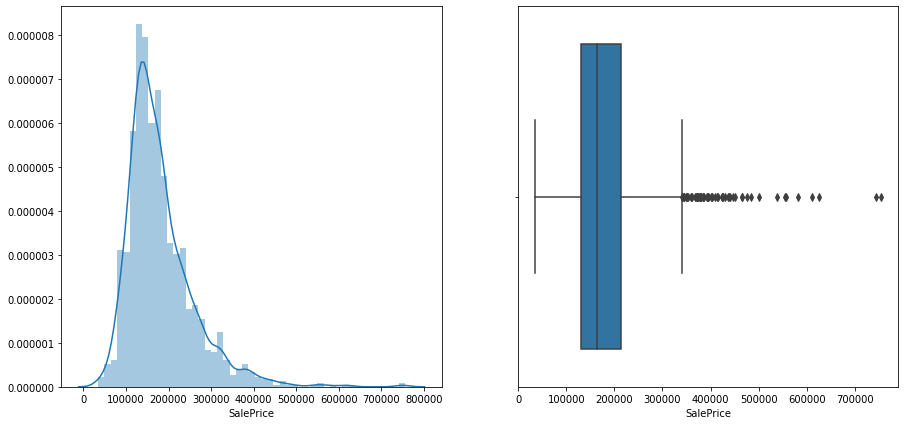

In [129]:
# target
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(train['SalePrice'])

plt.subplot(1,2,2)
sns.boxplot(train['SalePrice'])

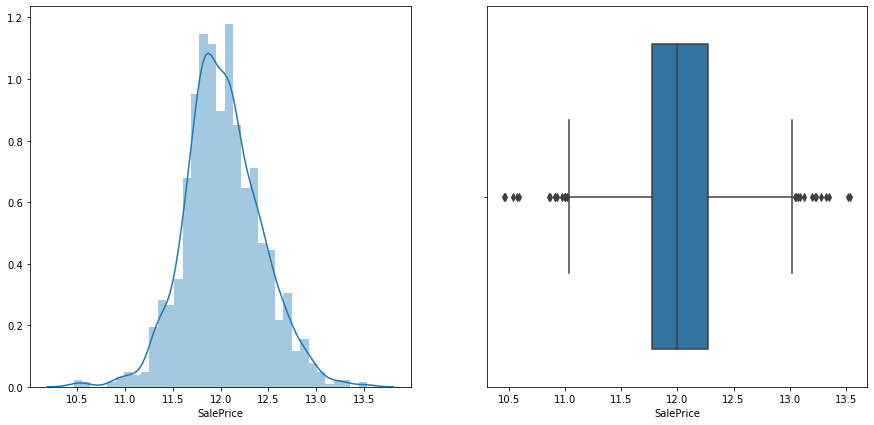

In [130]:
# target 에 log를 씌운다 
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.distplot(np.log(train['SalePrice']))

plt.subplot(1,2,2)
sns.boxplot(np.log(train['SalePrice']))

## 1. outlier delete

### Univariate outlier detection 
- EDA 과정이서 각 feature마다 outlier로 의심되는 부분을 체크했기에 해당하는 feature들을 살펴본다.
- test set에 비해 값이 큰 train을 위주로 살펴본다

- standard deviation : mean과 std를 이용하여 mean + - 3 * std 
- boxplot : IQR = q3-q1, (q1-1.5 * IQR, q3+1.5 * IQR)

In [5]:
outlier_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF']

In [51]:
def Standard_deviation(df, col):

    print('column name : ', col)
    mean_ = np.mean(df[col])
    sd_ = np.std(df[col])
    uppercut = mean_ + 3 * sd_
    lowercut = mean_ - 3* sd_
    upper_ = df[df[col] > uppercut][col]
    lower_ = df[df[col] < lowercut][col]
    print(f'upper count : {len(upper_)}개, {round(len(upper_)/len(df), 3)}')
    print(f'lower count : {len(lower_)}개, {round(len(lower_)/len(df), 3)}')
    plt.figure(figsize=(5,5))
    sns.distplot(df[col].dropna())

def Boxplot(df, col, cut=1.5):

    print('column name : ', col)
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    IQR = q3 - q1
    uppercut = q3 + cut * IQR 
    lowercut = q1 - cut * IQR
    upper_ = df[df[col] > uppercut][col]
    lower_ = df[df[col] < lowercut][col]
    print(f'upper count : {len(upper_)}개, {round(len(upper_)/len(df), 3)}')
    print(f'lower count : {len(lower_)}개, {round(len(lower_)/len(df), 3)}')
    plt.figure(figsize=(5,5))
    sns.boxplot(data=df,y=col, x='SalePrice_null')

column name :  1stFlrSF
upper count : 29개, 0.01
lower count : 0개, 0.0


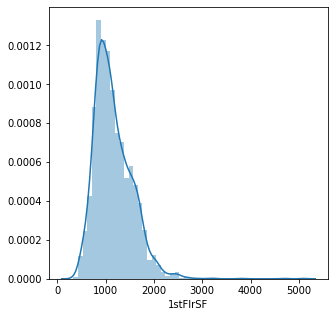

In [52]:
Standard_deviation(df, outlier_col[4] )

column name :  1stFlrSF
upper count : 5개, 0.002
lower count : 0개, 0.0


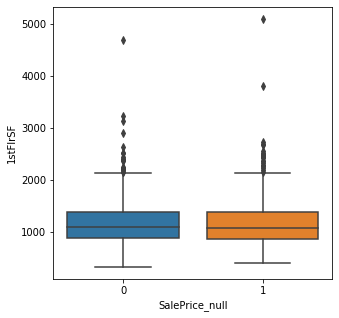

In [53]:
Boxplot(df, outlier_col[4], 3)

살펴본 결과 : 위 해당 columns들의 상위 0.1% 값 (즉, 상위 3개씩) 들을 지우기로 하였다.
- 다소 주관적이고 귀찮은 과정을 겪었지만 data 갯수가 적은 관계로 이렇게 진행하도록 한다.
- 나중에 다른 사람들은 어떤 식으로 했을지 궁금하다.

In [6]:
df_outdel = train.copy()

for i in outlier_col:
    df_outdel = df_outdel[df_outdel[i] != df_outdel[i].max()]
    df_outdel = df_outdel[df_outdel[i] != df_outdel[i].max()]
    df_outdel = df_outdel[df_outdel[i] != df_outdel[i].max()]
print(len(train)-len(df_outdel), "is deleted")

23 is deleted


In [7]:
df_outdel = pd.concat([df_outdel, test])

In [8]:
df_outdel['GarageYrBlt'].max()

2207.0

In [9]:
df_outdel['GarageYrBlt'] = df_outdel['GarageYrBlt'].replace(2207, 2007)
df_outdel['GarageYrBlt'].max()

2010.0

### Multivariate outlier detection
- 시간이 너무 오래걸릴 것 같아서 모든 feature를 고려할 수는 없었다
    - 일단, 위에서 나온 결과를 토대로 outlier들을 지우고
    -  numeric data 들로만 outlier detection을 해보기로 하였다

#### sklearn
- elliptic envelope :  fits a robust covariance estimate to the data, and thus fits an ellipse to the central data points, ignoring points outside the central mode.
- isolation forest : tree 기반 outlier detection
- LOF : density을 기반으로 outlier detection
- onclass SVM : onclass 라고 생각하고 SVM 이용

isolation forest를 사용하고 싶은데 NA 값이 있어서 안된다고 한다. NA값을 처리한 후에 사용하기로 한다.

이후 linearmodel을 사용할 때, numeric variable에 log를 취하면 될 것 같다.

# NA
- 라이브러리 활용 imputation
- NA 값 자체를 의미있게 생각하여 새로운 feature를 만들 수도 있지만 여기서는 skip하고자 한다

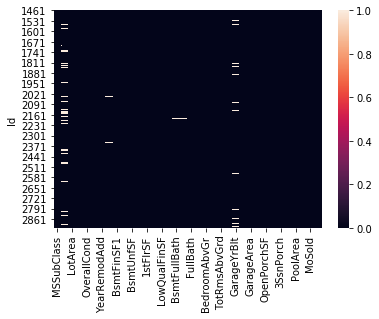

In [87]:
sns.heatmap(test[numeric_col].isnull())

test set 에 있는 NA는 지울수 없기 때문에 imputation 해야한다.

df 전체 NA 비율을 확인한다.

In [11]:
numeric_df = df_outdel[numeric_col]
na_df = pd.DataFrame(numeric_df.isnull().mean(), columns=['NA'])

In [12]:
namore70 = []
namore50 = []
namore0 = []
for i in range(len(na_df)):
    if na_df['NA'][i] > 0.7:
        namore70.append(na_df.index[i])
    elif na_df['NA'][i] > 0.5:
        namore50.append(na_df.index[i])
    elif na_df['NA'][i] > 0:
        namore0.append(na_df.index[i])

In [22]:
na_df

,NA
MSSubClass,0.000000
LotFrontage,0.166091
LotArea,0.000000
OverallQual,0.000000
OverallCond,0.000000
YearBuilt,0.000000
YearRemodAdd,0.000000
MasVnrArea,0.007942
BsmtFinSF1,0.000345
BsmtFinSF2,0.000345


In [13]:
print(namore70)
print(namore50)
print(namore0)

[]
[]
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [14]:
na_percent=[]
for i in namore0:
    na_percent.append(df[i].isnull().mean())

In [15]:
namore0

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [16]:
na_percent

[0.16649537512846865,
 0.0078794107571086,
 0.00034258307639602604,
 0.00034258307639602604,
 0.00034258307639602604,
 0.00034258307639602604,
 0.0006851661527920521,
 0.0006851661527920521,
 0.05447070914696814,
 0.00034258307639602604,
 0.00034258307639602604]

- 바로 imputation해보자.
    - https://scikit-learn.org/stable/modules/impute.html
    - https://data-newbie.tistory.com/257 : imputatioin 라이브러리 정리
    - 여러가지 방법이 있지만 sklearn만 이용한다.

In [17]:
print(df_outdel.shape)
print(df.shape)

(2896, 80)
(2919, 81)


원래는 imputation, scaling 들 모두 val, test set을 제외한 train data로 만 계산을 해야한다.
   - 하지만 여기서는 그냥 전체 df로 하였다
   
##### univariate imputation
   - mean
   - median
   
##### multivariate imputation
   - knn (거리기반 : scaling 필요)

In [18]:
train_outdel = df_outdel.dropna(subset=['SalePrice'])
test_outdel = df_outdel[df_outdel['SalePrice'].isnull()]

In [19]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df_outdel[numeric_col])
df_outdel_fillmean = imp_mean.transform(df_outdel[numeric_col])

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(df_outdel[numeric_col])
df_outdel_fillmedi = imp_median.transform(df_outdel[numeric_col])

In [20]:
df_outdel_fillmean = pd.DataFrame(df_outdel_fillmean, columns=numeric_col)
df_outdel_fillmedi = pd.DataFrame(df_outdel_fillmedi, columns=numeric_col)

In [98]:
# 아니 근데 scaling을 해야하는데
# scaling을 하여면 NA가 없어야한다
# 어찌할지 고민

# from sklearn.preprocessing import StandaedScaler
# >>> from sklearn.impute import KNNImputer
# >>> nan = np.nan
# >>> X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
# >>> imputer = KNNImputer(n_neighbors=2, weights="uniform")
# >>> imputer.fit_transform(X)

## data 저장

In [21]:
df_outdel_fillmean.to_pickle("df_outdel_fillmean.pkl")
df_outdel_fillmedi.to_pickle("df_outdel_fillmedi.pkl")
df_outdel.to_pickle("df_outdel.pkl")
train_outdel.to_pickle("train_outdel.pkl")
test_outdel.to_pickle("test_outdel.pkl")

### etc
1. numeric 이지만 category data라고 볼 수 있는 데이터 분석
2. Bsmt, Garage 등등 변수묶어서 좀 더 살펴보기
3. train과 test의 값이 다른 경우
4. 기본적으로 지울변수

### numeric 이지만 category data라고 볼 수 있는 데이터 분석
- 일단은 모두 numeric으로 취급하기로 하였다
- 추후에 모델 점수를 더 높이는 과정에서 추가적으로 살펴보기로 하자

### Bsmt, Garage 등등 변수묶어서 좀 더 살펴보기

In [100]:
def twoNumeric(df1, df2, col1, col2):
    print(df1[col1].corr(df2[col2]))
    plt.scatter(df1[col1], df2[col2])

0.3904711021443079


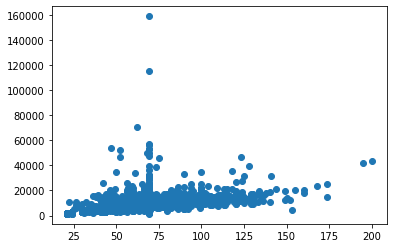

In [101]:
#  'LotFrontage', 'LotArea'
twoNumeric(df_outdel_fillmean, df_outdel_fillmean , 'LotFrontage', 'LotArea')

-0.09276352028664762


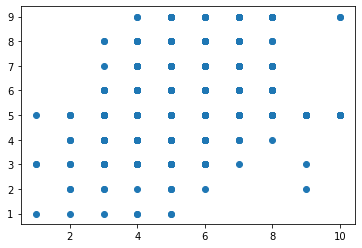

In [102]:
#  'OverallQual', 'OverallCond'
twoNumeric(df_outdel_fillmean, df_outdel_fillmean,'OverallQual', 'OverallCond')

0.6107963036433862


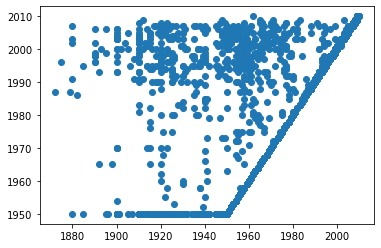

In [103]:
# YearBuilt, YearRemodAdd
twoNumeric(df_outdel_fillmean,df_outdel_fillmean ,'YearBuilt', 'YearRemodAdd')
# max 값에서 빼면 이 집이 얼마나 오래됐는지 파악가능할듯하다
# 불필요하게 큰 스케일값을 줄일수있을듯

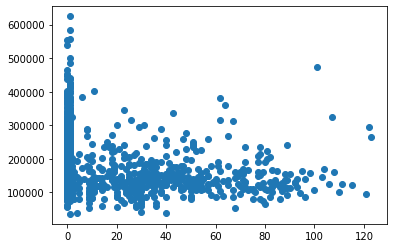

In [104]:
old = df_outdel['YearRemodAdd'] - df_outdel['YearBuilt']
plt.scatter(old[:len(train_outdel)], train_outdel['SalePrice'])
# 별 의미 없네

- 'BsmtFinSF1', : 없는 경우가 많다
- 'BsmtFinSF2', : 얘도 없는 경우가 많다
- 'BsmtUnfSF',
- 'TotalBsmtSF' = BsmtFinSF1 + BsmtFinSF2 +BsmtUnfSF, 이 feature 남기고 나머지 3개 지우면 될듯
- 'BsmtFullBath',
- 'BsmtHalfBath',

In [105]:
print(train_outdel['TotalBsmtSF'].corr(train_outdel['BsmtFinSF1']+train_outdel['BsmtFinSF2']+train_outdel['BsmtUnfSF']) )

1.0


- 'FullBath' : SalePrice와 양의 상관성 존재
- 'HalfBath' : 얘는 수정필요
- 둘 다 categorization 하는게 더 좋을듯 싶다 (특히, HalfBath)

- '1stFlrSF' : 1층 면적인듯
- '2ndFlrSF' : 0이 60%인데 아마 2층집이 아닌 경우 해당, 이를 통해 2층집인지 아닌지 feature 추가
- 'GrLivArea' = '1stFlrSF' + '2ndFlrSF' + 'LowQualFinSF
- 'BedroomAbvGr' : bedroom 갯수, 얘도 linear model 쓸때는 category 변수로 사용
- 'TotRmsAbvGrd' : bedroom 제외 방 갯수, 
- 'KitchenAbvGr' : 부엌 갯수 , 95% 가 1개 의미없다고 생각, 해당변수는 지우고 집 전체 방갯수 이런식으로 feature 추가

0.9999999999999999


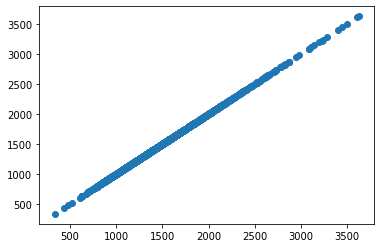

In [106]:
print(train_outdel['GrLivArea'].corr(train_outdel['1stFlrSF']+train_outdel['2ndFlrSF']+train_outdel['LowQualFinSF']) )
plt.scatter(train_outdel['GrLivArea'],train_outdel['1stFlrSF']+train_outdel['2ndFlrSF']+train_outdel['LowQualFinSF'])

- 'GarageYrBlt' : YearRemodAdd,YearBuilt와 밀접한 관련 상관관계도 높다
- 'GarageCars' : 0~3까지 SalePrice와 선형관계가 있어보이지만 4를 갖는 값이 16개밖에 안되고 선형 x (차 들어가는 갯수)
- 'GarageArea' : GarageArea를 discret화 한게 GarageCars라고 할 수 있을 것 같다

0.843095695926937


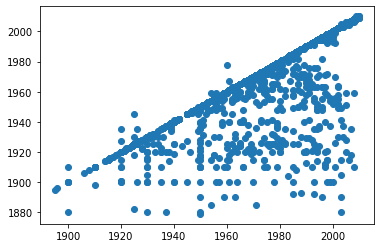

In [107]:
twoNumeric(df_outdel, df_outdel, 'GarageYrBlt', 'YearBuilt')

0.6578400599490759


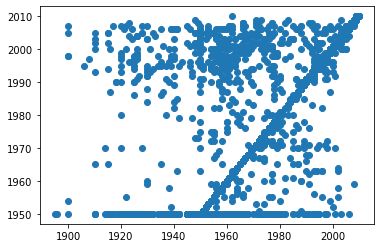

In [108]:
twoNumeric(df_outdel, df_outdel, 'GarageYrBlt', 'YearRemodAdd')

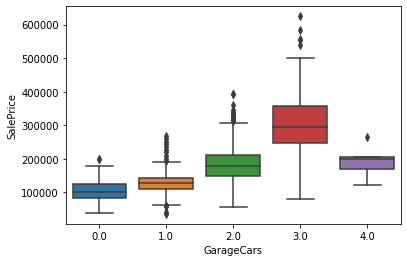

In [111]:
sns.boxplot(data=train_outdel, x='GarageCars', y='SalePrice')

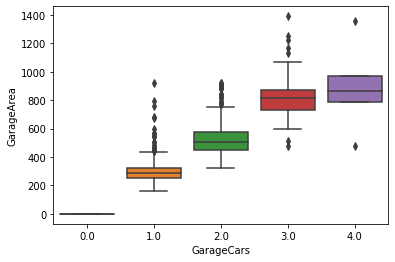

In [114]:
sns.boxplot(data=train_outdel, x='GarageCars', y='GarageArea')

- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
    - zero인 경우가 많아서 feature들 합치거나  0 or not 으로 나누는 등의 조작 필요

- 'PoolArea' : 99.6%가 0을 갖는다
- 'MiscVal' : 96.5%가 0을 갖는다
- 'MoSold' : 팔린 month
- 'YrSold' : 팔린 year
- 둘다 범주화 or 지우기 생각

### train과 test의 값이 다른 경우
- 'Fireplaces' : test에만 4 존재
- 'GarageCars' : test에만 5 존재